In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 5. Conjugate gradient
**Nonlinear conjugate gradient** (NCG) methods are methods of the following form:
$$
s_t \leftarrow \nabla f(x_t) + \beta_t s_{t-1}
$$
$$
x_{t+1} \leftarrow x_t - \eta s_t
$$
So a conjugate gradient direction is gradient plus previous direction times $\beta_t$. The only difference between most conjugate gradient methods is how $\beta_t$ is calculated. For example Fletcher–Reeves formula is the following:
$$
\beta_t^\text{FR}=\frac{g_t^T g_t}{g_{t-1}^T g_{t-1}}
$$
Here $g_t$ is gradient: $\nabla f(x_t)$. I will write it as $g_t$ to make it more readable.

Conjugate gradient is guaranteed to minimize convex quadratic function of $n$ variables in at most $n$ steps. All conjugate gradient methods are equivalent on a quadratic function, so the difference is how they behave on other functions. Generally CG can be thought of as very computationally inexpensive alternative to Quasi-Newton methods.



Consider the following quadratic function:
$$
f(x) = (2*x + 3*y - 5)^2 + (5*x - 2*y - 3)^2
$$

If we run gradient descent with a line search, we see a staircase-like path, whereas CG is guaranteed to minimize it in two steps.

finished in 0.0s., reached loss = 9.86e-10                                      
finished in 0.0s., reached loss = 4.8e-11                                      


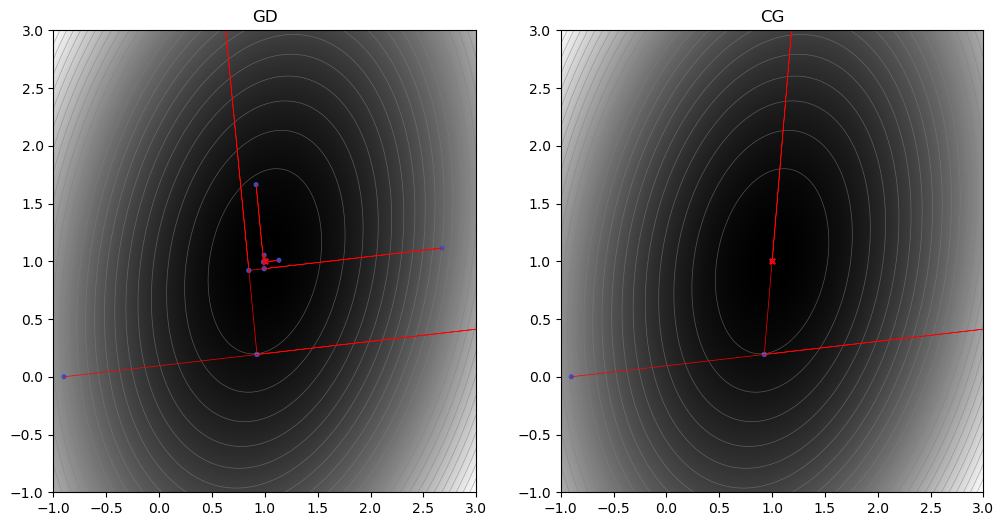

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax = np.ravel(ax)
# ---------------------------------- GD ---------------------------------- #
func = FunctionDescent("lstsq")
optimizer = tz.Modular(
    func.parameters(),
    tz.m.StrongWolfe(c2=0.1, a_init="first-order"),
)
func.run(optimizer, max_steps=10)
func.plot(ax=ax[0])
ax[0].set_title("GD")

# ------------------------------- CG ------------------------------ #
func = FunctionDescent("lstsq")
optimizer = tz.Modular(
    func.parameters(),
    tz.m.FletcherReeves(),
    tz.m.StrongWolfe(c2=0.1, a_init="first-order"),
)
func.run(optimizer, max_steps=2)
func.plot( ax=ax[1])
ax[1].set_title("CG")

plt.show()

The way CG should generally be used in torchzero is this:
```python
optimizer = tz.Modular(
    model.parameters(),
    tz.m.BirginMartinezRestart(tz.m.FletcherReeves()),
    tz.m.StrongWolfe(c2=0.1, a_init="first-order", fallback=True),
)
```

CG should be restarted every once in a while. For example a simple restarting strategy is restarting every $n$ steps, where $n$ is number of variables, which we can do by passing ``restart_interval="auto"``, or specify an integer. Torchzero also implements Powell's[1] and Birgin-Martinez[2] restart strategies.

The ``StrongWolfe`` line search is recommended because CG requires step size to be determined accurately to work. 

CG doesn't produce well-scaled updates, therefore we use the `a_init="first-order"` argument which sets initial step size by assuming first-order change in the function at current iterate will be the same as that obtained at the previous step.

``c2=0.1`` sets tolerance for curvature condition to 0.1 (by default it is 0.9), meaning curvature condition is stronger. The value of 0.1 is suggested in *[Jorge Nocedal and Stephen J. Wright - Numerical Optimization](https://www.math.uci.edu/~qnie/Publications/NumericalOptimization.pdf)*.

However it is possible that there is no point which satisfies curvature condition of 0.1, especially on weirder functions, meaning the line search will never propose a new point and optimization gets stuck. By setting ``fallback=True``, when no point satisfying the conditions is found after maximum number of iterations, we allow line search to return the lowest point it found.

[1] *Powell, Michael James David. "Restart procedures for the conjugate gradient method." Mathematical programming 12.1 (1977): 241-254.*

[2] *[Birgin, Ernesto G., and José Mario Martínez. "A spectral conjugate gradient method for unconstrained optimization." Applied Mathematics & Optimization 43.2 (2001): 117-128.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=6c8145663e88940dfbae191760e701018e0fb1da)*

finished in 0.2s., reached loss = 5.527                                      
finished in 0.3s., reached loss = 3.69e-13                                      


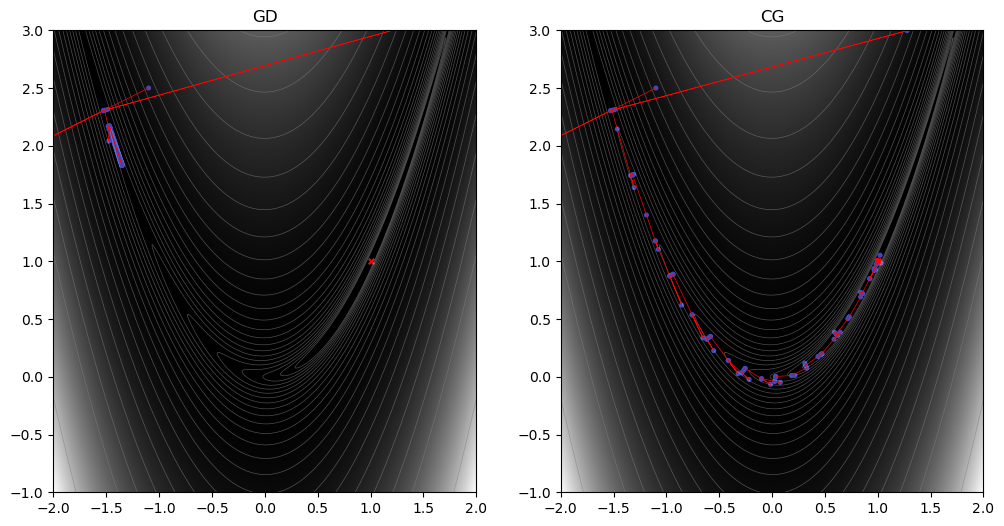

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax = np.ravel(ax)
# ---------------------------------- GD ---------------------------------- #
func = FunctionDescent("rosen")
optimizer = tz.Modular(
    func.parameters(),
    tz.m.StrongWolfe(c2=0.1, a_init="first-order", fallback=True),
)
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("GD")

# ------------------------------- CG ------------------------------ #
func = FunctionDescent("rosen")
optimizer = tz.Modular(
    func.parameters(),
    tz.m.BirginMartinezRestart(tz.m.FletcherReeves()),
    tz.m.StrongWolfe(c2=0.1, a_init="first-order", fallback=True),
)
func.run(optimizer, max_steps=50)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("CG")

plt.show()

### Conjugate gradient methods in torchzero
torchzero implements the following NCGs:
- **FletcherReeves**
- **PolakRibiere**
- **DaiYuan**
- **HagerZhang**
- **HestenesStiefel**
- **LiuStorey**
- **ConjugateDescent**
- **DYHS**
- **ProjectedGradientMethod**

Different formulas will perform better on different problems.

**Projected gradient method** described in [1] (algorithm 5 in section 6) directly projects the gradient onto a subspace that is conjugate to past directions, therefore it represents a "perfect" CG, however it requires $N^2$ memory. If you can afford that, the projected gradient method may compete with quasi-newton methods. (note that this is different from projected gradient descent for constrained optimization).

Another related algorithm is **Shor's r-algorithm**[2], which with hyperparameter $\alpha=1$ becomes a conjugate gradient method and with $\alpha=0$ is equivalent to steepest descent. Shor's r-algorithm is at the same time very different from CG and it specifically intended for non-smooth functions. It typically works best with $\alpha=0.5$.

[1] *Pearson, J. D. (1969). Variable metric methods of minimisation. The Computer Journal, 12(2), 171–178. doi:10.1093/comjnl/12.2.171.*

[2] *S HOR , N. Z. (1985) Minimization Methods for Non-differentiable Functions. New York: Springer.*

finished in 0.3s., reached loss = 3.69e-13                                      
finished in 0.2s., reached loss = 3.54e-07                                      
finished in 0.3s., reached loss = 8.58e-09                                      
finished in 0.2s., reached loss = 6e-13                                      
finished in 0.2s., reached loss = 5.68e-14                                      
finished in 0.2s., reached loss = 1.72e-12                                      
finished in 0.2s., reached loss = 1.64e-12                                      
finished in 0.2s., reached loss = 5.68e-12                                      
finished in 0.2s., reached loss = 1.28e-13                                      


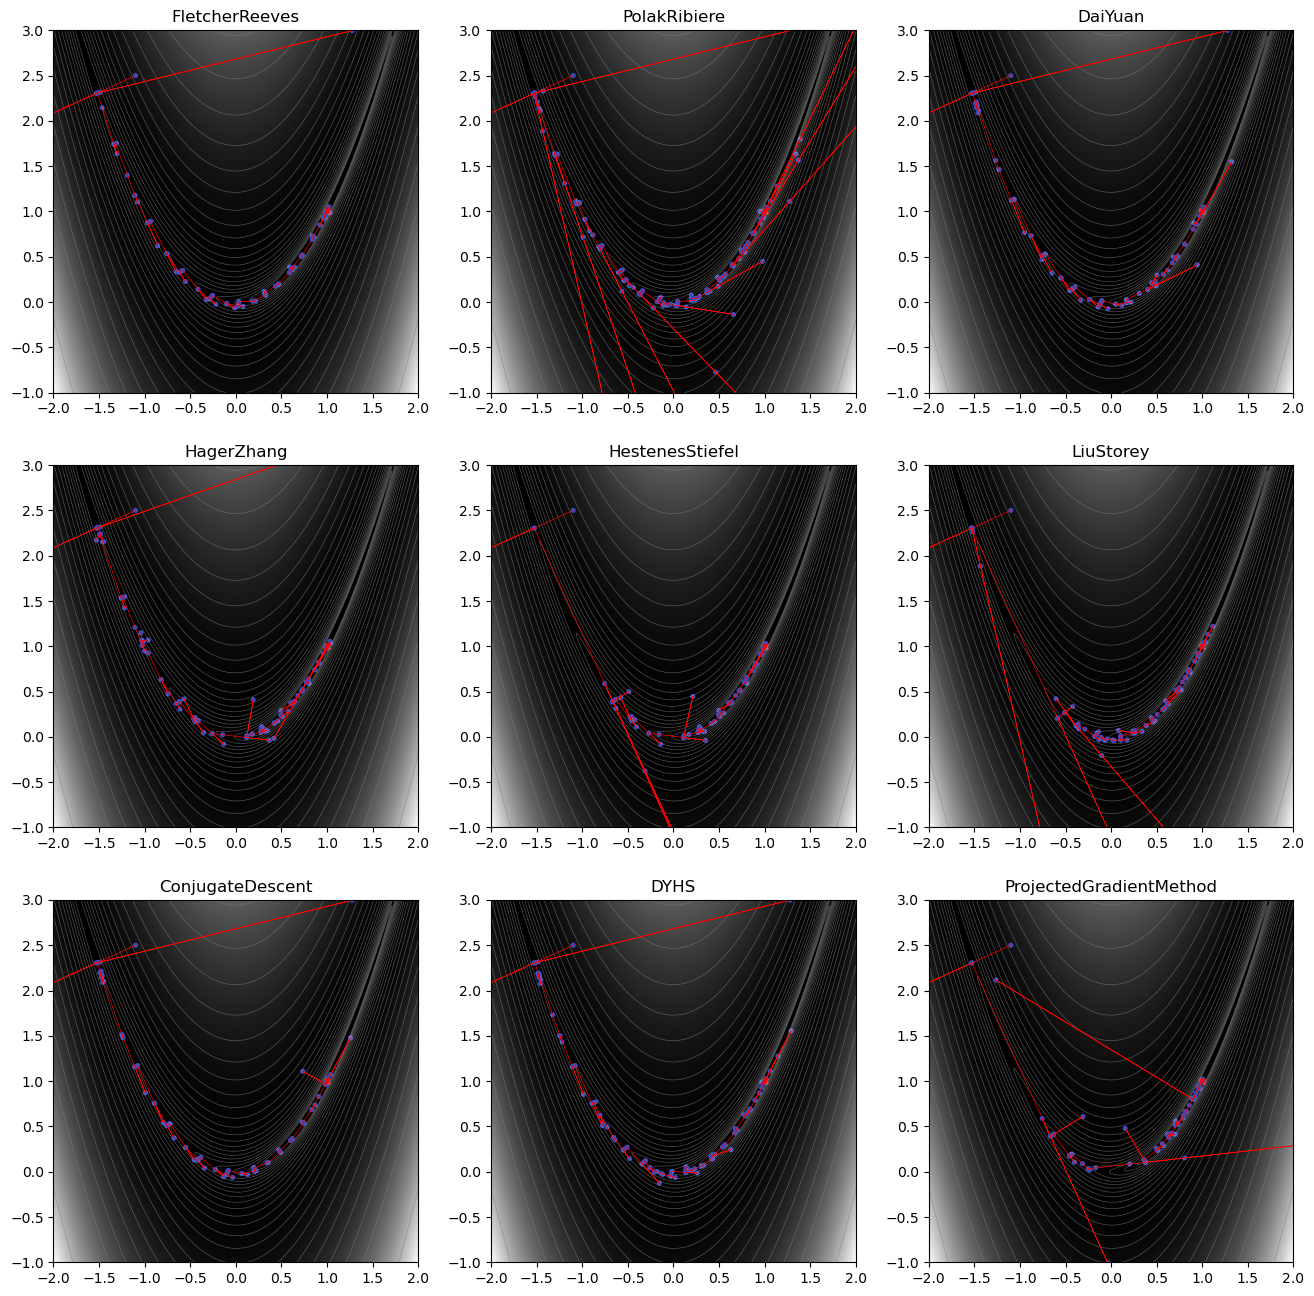

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16,16))
axes = np.ravel(axes)
axes_iter = iter(axes)

for CG in tz.m.FletcherReeves, tz.m.PolakRibiere, tz.m.DaiYuan, tz.m.HagerZhang, tz.m.HestenesStiefel, tz.m.LiuStorey, tz.m.ConjugateDescent, tz.m.DYHS, tz.m.ProjectedGradientMethod:
    ax = next(axes_iter)
    func = FunctionDescent("rosen")
    optimizer = tz.Modular(
        func.parameters(),
        CG(restart_interval=3),
        tz.m.StrongWolfe(c2=0.1, a_init="first-order", fallback=True),
    )
    func.run(optimizer, max_steps=50)
    func.plot(log_contour=True, ax=ax)
    ax.set_title(CG.__name__)


plt.show()

### Adaptive Heavy-ball

Adaptive Heavy-ball is a combination of CG, heavy-ball momentum and Polyak's step size. It is mainly suitable for convex quadratic functions with known value at minima $f*$, although it may work on non-quadratic convex functions too. Adaptive Heavy-ball requires no tuning and no line search.

Reference: *Goujaud, Baptiste, Adrien Taylor, and Aymeric Dieuleveut. "Short Paper-Quadratic minimization: from conjugate gradient to an adaptive Polyak’s momentum method with Polyak step-sizes." Open Journal of Mathematical Optimization 5 (2024): 1-10.*

finished in 0.0s., reached loss = 0                                      


<Axes: >

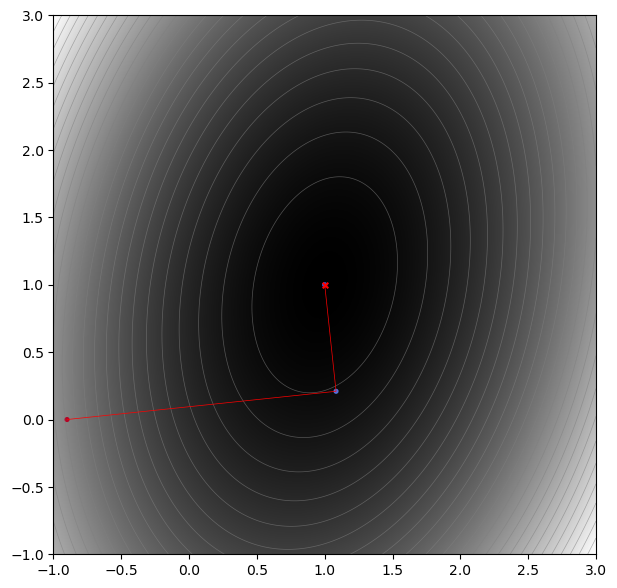

In [25]:
func = FunctionDescent('lstsq')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.AdaptiveHeavyBall(),
)
func.run(optimizer, max_steps=4)
func.plot()